### Курсовой проект


In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import GridSearchCV, KFold

# Графика
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns 

# Работа с датой
import datetime

# Статические распределения
from scipy import stats

%matplotlib inline

In [2]:
# Не печатать предупреждения
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 12})

***Пути к директориям и файлам***

In [4]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREPARED_DATASET_PATH = 'train_prepared.csv'

### Загрузка данных

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH,sep=',')

In [6]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [7]:
# Проверим типы данных
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


### Опимизация данных

In [9]:
def reduce_mem_usage(df):
    """
    Функция переберает все столбцы в датафрейме и
    измяняет тип данных
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Используемая память для датафрейма состовляет {:.2f} MB'.format(start_mem))
    i = 0
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            # для 
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Используемая память после оптимизации датафрейма состовляет {:.2f} MB'.format(end_mem))
    print('Датафрейм уменьшился на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
train_df = reduce_mem_usage(train_df)

Используемая память для датафрейма состовляет 1.53 MB
Используемая память после оптимизации датафрейма состовляет 0.49 MB
Датафрейм уменьшился на 68.1%


### Приведение типов

In [11]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [12]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Анализ данных EDA

**Целевая переменная**

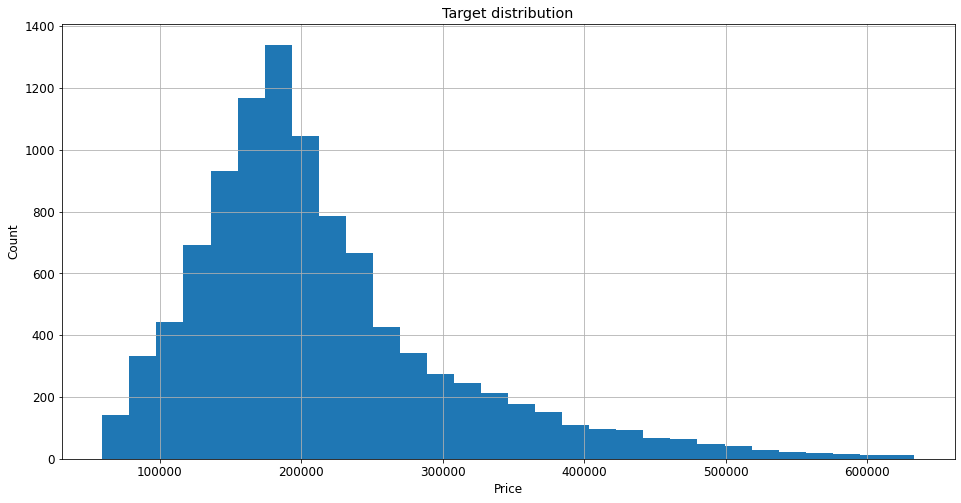

In [13]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [14]:
# Количественные переменные
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [15]:
# Категориальные переменные
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId']

### Обработка выбросов

In [16]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [17]:
# Проверка целая ли число медиана, т.к. кол-во комнат всегда целое число
train_df['Rooms'].median()

2.0

In [18]:
# Приведение к целому числу медианы
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = int(train_df['Rooms'].median())

In [19]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.812107,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,6.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [20]:
# Приводим общую площадь, жилую площадь, площадь кухни, к адекватным значениям. 
# Т.е. исключаем данные не подходящиие под выборку квантили

train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]
        
train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]
        
train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

In [21]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,8881.000000,8881.000000,7296.000000,8881.000000,8881.000000,8881.000000,8.881000e+03,8881.000000,8881.000000,8881.000000,8881.000000,4799.000000,8881.000000,8881.000000,8881.000000
mean,1.884585,54.809338,34.830330,6.075329,8.446684,12.826934,4.242532e+03,0.119622,26.071163,5630.480014,8.403783,1156.072876,1.392636,4.438577,214939.406250
std,0.797014,16.225330,14.280533,3.503585,5.133763,6.369226,2.127571e+05,0.119654,17.269698,3977.902810,24.295214,1032.815308,1.492092,4.837340,89654.179688
min,1.000000,29.719934,2.941437,1.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.637554,22.863804,1.000000,4.000000,9.000000,1.972000e+03,0.017647,10.000000,2370.000000,0.000000,325.000000,0.000000,1.000000,156934.437500
50%,2.000000,51.656013,32.459930,6.000000,7.000000,14.000000,1.977000e+03,0.075779,25.000000,5562.000000,2.000000,990.000000,1.000000,3.000000,194240.531250
75%,2.000000,64.720917,44.119770,9.000000,12.000000,17.000000,2.000000e+03,0.194489,36.000000,7614.000000,5.000000,1548.000000,3.000000,6.000000,250381.578125
max,6.000000,117.855972,88.381355,14.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [22]:
# Проверим сколько наблюдений квартир с обшей площадью меньше, чем кунхя + жилаая площадь вместе
mask = train_df['Square'] < train_df['KitchenSquare'] + train_df['LifeSquare']
train_df.loc[mask].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,250.000000,652.000000,652.000000,652.000000
mean,1.648773,53.937710,53.975311,4.766871,9.946319,14.760736,2000.834356,0.107157,16.115031,3707.608896,9.110429,889.080017,0.878834,3.461656,190942.562500
std,0.735922,14.718971,14.697445,4.290275,5.805755,8.616316,19.706764,0.109550,16.929164,3944.012120,29.387084,723.284851,1.344859,5.290638,85871.148438
min,1.000000,29.719934,22.892380,1.000000,1.000000,0.000000,1918.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59877.593750
25%,1.000000,41.318307,41.593620,1.000000,5.000000,10.000000,1977.000000,0.011654,2.000000,629.000000,0.000000,540.000000,0.000000,0.000000,132108.089844
50%,1.000000,51.306313,50.900047,1.000000,9.000000,17.000000,2015.000000,0.072158,6.000000,1564.000000,1.000000,705.000000,0.000000,1.000000,171791.695312
75%,2.000000,64.653078,64.342663,10.000000,14.000000,17.000000,2017.000000,0.195781,26.000000,6138.000000,4.000000,1046.000000,2.000000,5.000000,228633.695312
max,5.000000,89.118210,88.381355,14.000000,28.000000,117.000000,2020.000000,0.486246,74.000000,19083.000000,141.000000,4508.000000,6.000000,23.000000,573539.687500


In [23]:
# Установим минимальное значение для жилой площади
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [24]:
# Установим минимальное значение для площади кухни
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [25]:
# Расмотрим этажности домов
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        39.,  40.,  44.,  45.,  48.,  99., 117.], dtype=float32)

In [26]:
# Расмотрим этажности квартир
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 42],
      dtype=int8)

In [27]:
# Заменим 0 этажность на медиану
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [28]:
train_df['HouseFloor'].sort_values().unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,  39.,
        40.,  44.,  45.,  48.,  99., 117.], dtype=float32)

In [29]:
# Проверим есть ли такие квартиры которые расположены выше, чем этажнсть дома 
floor_outlires = train_df[train_df['Floor'] > train_df['HouseFloor']].index

In [30]:
# Зададим случайные значения для таких квартир, у которых этажность квартиры выше дома
train_df.loc[floor_outlires, 'Floor'] = train_df.loc[floor_outlires, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)

In [31]:
# Проверим данные по году постройки дома
train_df['HouseYear'].sort_values().unique()

array([    1914,     1916,     1917,     1918,     1919,     1928,
           1929,     1930,     1931,     1932,     1933,     1934,
           1935,     1936,     1937,     1938,     1939,     1940,
           1941,     1942,     1947,     1948,     1950,     1951,
           1952,     1953,     1954,     1955,     1956,     1957,
           1958,     1959,     1960,     1961,     1962,     1963,
           1964,     1965,     1966,     1967,     1968,     1969,
           1970,     1971,     1972,     1973,     1974,     1975,
           1976,     1977,     1978,     1979,     1980,     1981,
           1982,     1983,     1984,     1985,     1986,     1987,
           1988,     1989,     1990,     1991,     1992,     1993,
           1994,     1995,     1996,     1997,     1998,     1999,
           2000,     2001,     2002,     2003,     2004,     2005,
           2006,     2007,     2008,     2009,     2010,     2011,
           2012,     2013,     2014,     2015,     2016,     2

In [32]:
# Так как странных значения всего 2, замени на константу
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2017

In [33]:
# Проеверим
train_df['HouseYear'].sort_values().unique()

array([1914, 1916, 1917, 1918, 1919, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1947, 1948,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020], dtype=int32)

### Обработаем пропуски

In [34]:
# Проверим пропуски
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1585
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4082
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [35]:
# Посмотрим данные
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027313,NaN,10.0
1,39.832523,23.169222,8.0
2,78.342216,47.671970,10.0
3,40.409908,NaN,3.0
4,64.285065,38.562515,9.0
5,62.528465,47.103832,6.0
6,33.938751,21.772930,9.0
7,50.391815,32.893257,8.0
8,46.887894,44.628132,3.0
9,79.867477,75.085129,3.0


In [36]:
# Померим медиану площади

In [37]:
train_df['LifeSquare'].median()

32.459930419921875

In [38]:
# Подсчитаем разнацу между общей площа-ди, жилой и кухни
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()
square_med_diff

11.490550994873047

In [39]:
# Заполним пустые значения
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [40]:
# Признак Healtare (Показатель местности)
train_df['Healthcare_1'].head()

0       NaN
1    1183.0
2     240.0
3       NaN
4       NaN
Name: Healthcare_1, dtype: float32

In [41]:
# Заменим пустые признаки на медиану
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### Построение новых признаков

In [42]:
train_df['Ecology_2']

0       B
1       B
2       B
3       B
4       B
       ..
9994    B
9995    B
9996    B
9998    B
9999    B
Name: Ecology_2, Length: 8881, dtype: category
Categories (2, object): ['A', 'B']

In [43]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [44]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.00000
mean,1.884585,54.809338,36.559097,6.589798,7.350186,12.849004,1984.571557,0.119622,26.071163,5630.480014,8.403783,1079.740356,1.392636,4.438577,214939.406250,0.989979,0.969936,0.92940
std,0.797014,16.225330,15.036618,2.795868,4.969127,6.348860,18.371954,0.119654,17.269698,3977.902810,24.295214,763.674255,1.492092,4.837340,89654.179688,0.099610,0.170774,0.25617
min,1.000000,29.719934,10.000000,3.000000,1.000000,1.000000,1914.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344,0.000000,0.000000,0.00000
25%,1.000000,41.637554,23.916309,3.000000,3.000000,9.000000,1972.000000,0.017647,10.000000,2370.000000,0.000000,810.000000,0.000000,1.000000,156934.437500,1.000000,1.000000,1.00000
50%,2.000000,51.656013,33.273701,6.000000,6.000000,14.000000,1977.000000,0.075779,25.000000,5562.000000,2.000000,990.000000,1.000000,3.000000,194240.531250,1.000000,1.000000,1.00000
75%,2.000000,64.720917,46.039589,9.000000,10.000000,17.000000,2000.000000,0.194489,36.000000,7614.000000,5.000000,1036.000000,3.000000,6.000000,250381.578125,1.000000,1.000000,1.00000
max,6.000000,117.855972,102.809479,14.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500,1.000000,1.000000,1.00000


In [45]:
train_df['Ecology_3_bin'].value_counts()

1    8614
0     267
Name: Ecology_3_bin, dtype: int64

In [46]:
now = datetime.datetime.now()

In [47]:
# Создадим новый признак  (возраст дома)
train_df['HouseYear_old'] = now.year - train_df['HouseYear']

In [48]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,HouseYear_old
9994,4356,9,1.0,43.303459,21.519087,8.0,12,14.0,1992,0.161532,...,1,30.0,2,4,B,136744.343750,1,1,1,30
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,...,6,990.0,1,9,B,119367.453125,1,1,1,41
9996,16265,27,2.0,64.307686,37.038422,9.0,13,14.0,1977,0.072158,...,1,990.0,0,0,A,199715.156250,1,1,0,45
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,3,125.0,3,5,B,171842.406250,1,1,1,53
9999,7202,94,1.0,35.815475,22.301367,6.0,9,9.0,1975,0.127376,...,3,990.0,3,9,B,177685.625000,1,1,1,47


### Визуализация данных

In [49]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode =train_df['Price'].mode()[0]

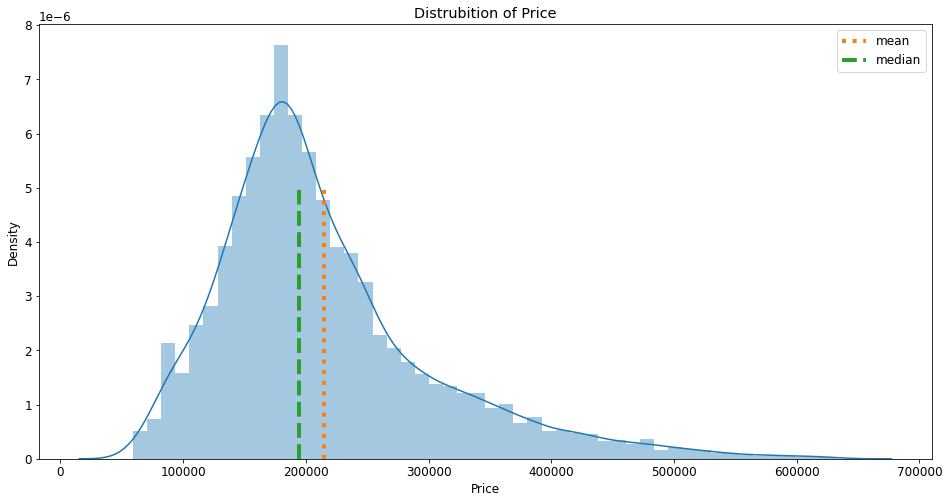

In [50]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y=np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
#plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distrubition of Price')
plt.legend()
plt.show()

In [51]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16', 'int64', 'int32'])
train_df_num_features.drop('Price', axis=1, inplace=True)

In [52]:
train_df.dtypes

Id                 object
DistrictId         object
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor               int64
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
Ecology_2_bin       int64
Ecology_3_bin       int64
Shops_2_bin         int64
HouseYear_old       int32
dtype: object

In [53]:
train_df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Healthcare_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,HouseYear_old
0,3.0,115.027313,93.536758,10.0,4,10.0,2014,0.075424,990.0,1,1,1,8
1,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1183.0,1,1,1,56
2,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,240.0,1,1,1,34
3,1.0,40.409908,25.919357,3.0,10,22.0,1977,0.007122,990.0,1,1,1,45
4,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,990.0,1,1,1,50


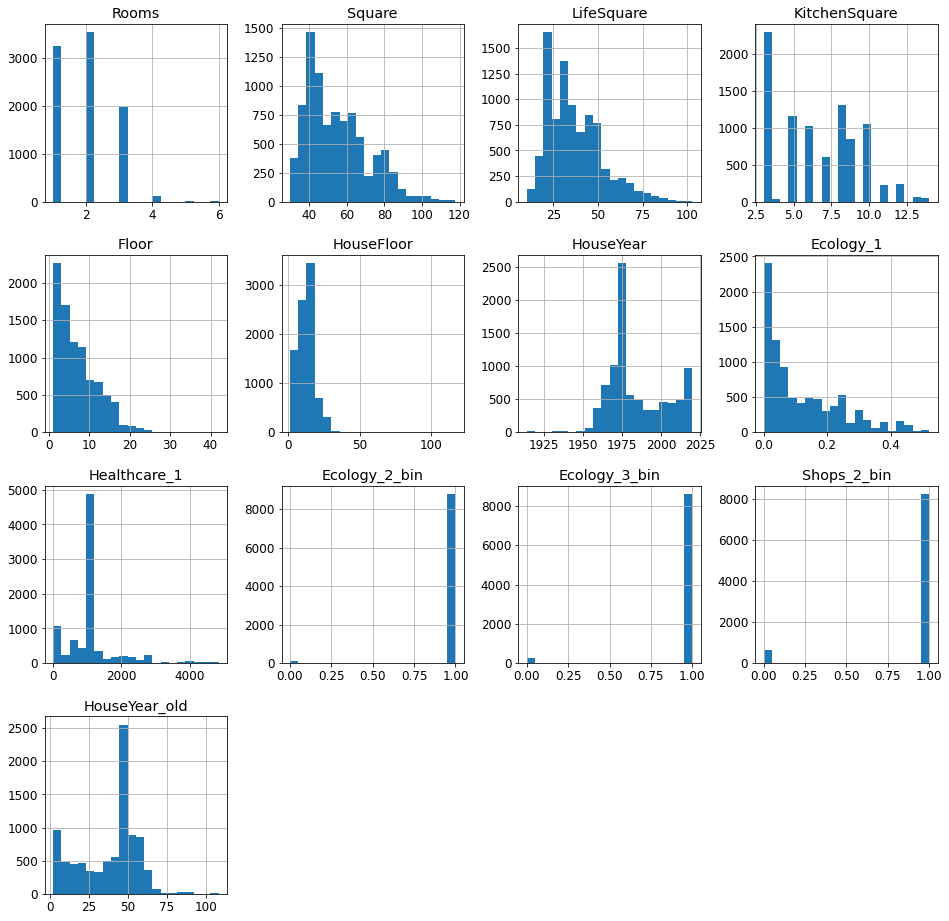

In [54]:
train_df_num_features.hist(figsize=(16, 16), bins=20);

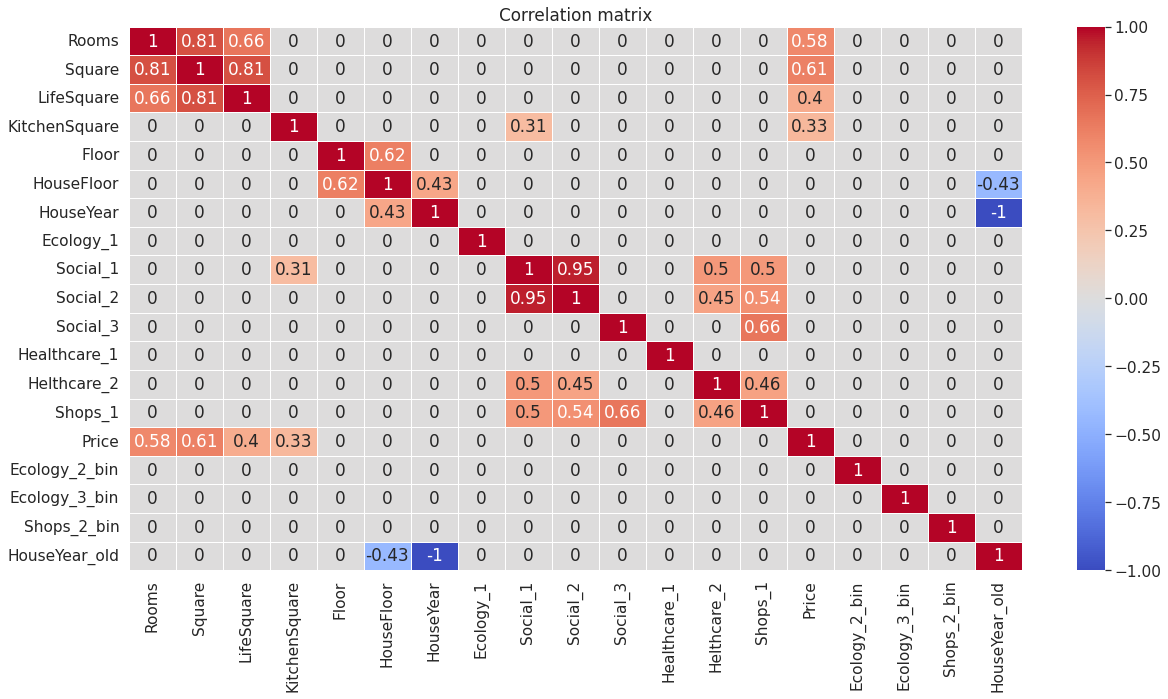

In [55]:
# Построим матрицу зависимостей
plt.figure(figsize=(20, 10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

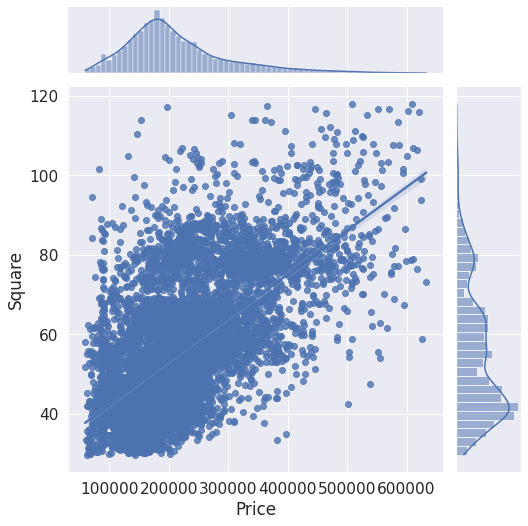

In [56]:
grid = sns.jointplot(train_df['Price'], train_df['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

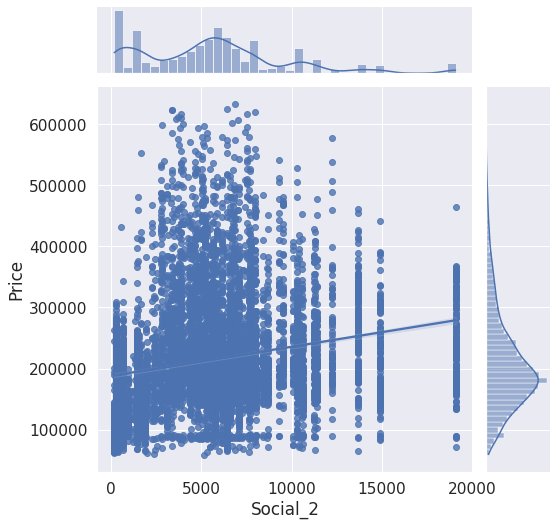

In [57]:
grid = sns.jointplot(train_df['Social_2'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

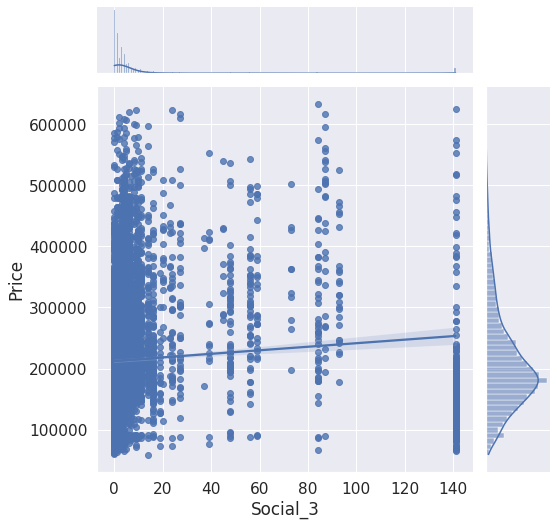

In [58]:
grid = sns.jointplot(train_df['Social_3'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

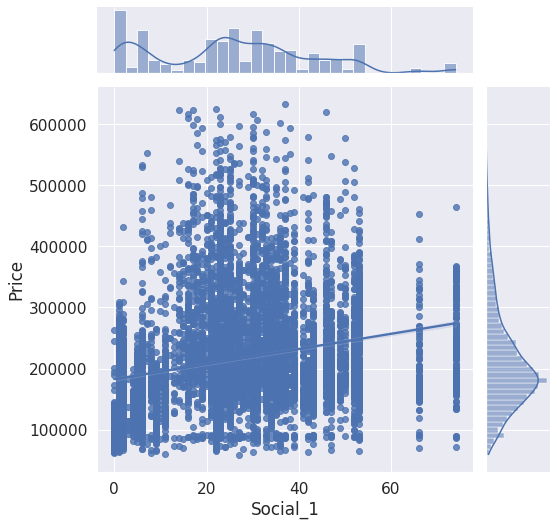

In [59]:
grid = sns.jointplot(train_df['Social_1'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

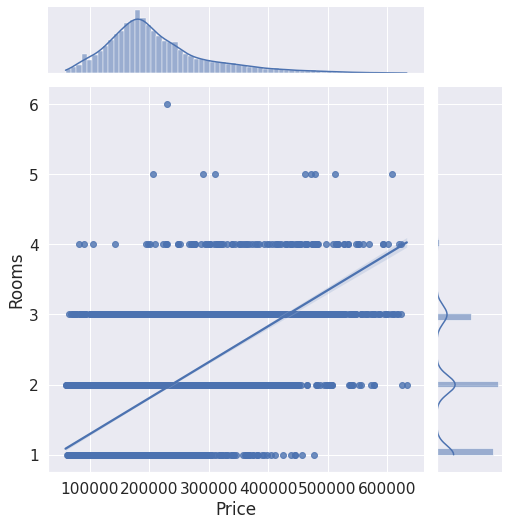

In [60]:
grid = sns.jointplot(train_df['Price'], train_df['Rooms'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### Отбор признаков

In [61]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'HouseYear_old']

In [62]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1']

new_feature_names = ['Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin', 'HouseYear_old']

target_name = 'Price'

In [63]:
class DataPipeline:
    '''Подготовка исходных данных'''
    
    def __init__(self):
        '''Параметры класса'''
        # медианы
        self.rooms_medians = None
        self.house_floor_medians = None
        self.square_med_diff = None
        self.healthcare_1_median = None
        
        # константы
        self.house_year = 2017  # год постройки дома для выбросов
        self.min_life_square = 10  # минимальная площадь жилой площади
        self.min_kitchen_square = 3  # минимальная площадь кухни


    def fit(self, X):
        '''Сохранение статистик'''
        
        # Расчет медиан
        self.rooms_medians = X['Rooms'].median()
        self.house_floor_medians = X['HouseFloor'].median()
        self.healthcare_1_median = X['Healthcare_1'].median()
            # Подсчитаем разнацу между общей площа-ди, жилой и кухни
        self.square_med_diff = (X.loc[X['LifeSquare'].notnull(), 'Square'] -\
                                X.loc[X['LifeSquare'].notnull(), 'LifeSquare'] -\
                                X.loc[X['LifeSquare'].notnull(), 'KitchenSquare']).median()
    
    
    def trasform(self, X):
        '''Трансформация данных'''
        
        #2. Выбросы
        
        # Приводим общую площадь, жилую площадь, площадь кухни, к адекватным значениям. 
        # Т.е. исключаем данные не подходящиие под выборку квантили
            
        if X.shape[0] == 5000:
            pass
        else:
                # для общей площади
            X = X[X['Square'].isnull() |
                        (X['Square'] < X['Square'].quantile(.99)) &
                        (X['Square'] > X['Square'].quantile(.01))]
                # для жилой площади
            X = X[X['LifeSquare'].isnull() |
                        (X['LifeSquare'] < X['LifeSquare'].quantile(.99)) &
                        (X['LifeSquare'] > X['LifeSquare'].quantile(.01))]
                # для кухни
            X = X[X['KitchenSquare'].isnull() |
                        (X['KitchenSquare'] < X['KitchenSquare'].quantile(.99)) &
                        (X['KitchenSquare'] > X['KitchenSquare'].quantile(.01))]
        
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = self.house_year
        X.loc[X['LifeSquare'] < 10, 'LifeSquare'] = self.min_life_square
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = self.min_kitchen_square
        
        #1. Пропуски
        X.loc[X['Rooms'].isin([0, 10, 19]), 'Rooms'] = self.rooms_medians
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.house_floor_medians
        X.loc[X['Healthcare_1'].isnull(), 'Healthcare_1'] = self.healthcare_1_median
        
        X.loc[X['LifeSquare'].isnull(), 'LifeSquare'] =\
        X.loc[X['LifeSquare'].isnull(), 'Square'] -\
        X.loc[X['LifeSquare'].isnull(), 'KitchenSquare'] -\
        self.square_med_diff
        
        # Зададим случайные значения для таких квартир, у которых этажность квартиры выше дома
        floor_outlires = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outlires, 'Floor'] = X.loc[floor_outlires, 'HouseFloor']\
                                                    .apply(lambda x: random.randint(1, x))
                         
        #3. Новые признаки
        
        X['Ecology_2_bin'] = X['Ecology_2'].replace({'A':0, 'B':1})
        X['Ecology_3_bin'] = X['Ecology_3'].replace({'A':0, 'B':1})
        X['Shops_2_bin'] = X['Shops_2'].replace({'A':0, 'B':1})
        
        # Создадим новый признак (возраст дома)
        
        X['HouseYear_old'] = datetime.datetime.now().year - X['HouseYear']
        
        return X

### Разбиение на train и test 

In [64]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [65]:
# Оптимизация типов данных
train_df = reduce_mem_usage(train_df)

Используемая память для датафрейма состовляет 1.53 MB
Используемая память после оптимизации датафрейма состовляет 0.49 MB
Датафрейм уменьшился на 68.1%


In [66]:
X_train, X_valid, y_train, y_valid =\
train_test_split(X, y, test_size=0.33, random_state=21)

In [67]:
preprocessor = DataPipeline()
preprocessor.fit(X_train)

In [68]:
X_train = preprocessor.trasform(X_train)
X_valid = preprocessor.trasform(X_valid)
test_df = preprocessor.trasform(test_df)

X_train.shape, X_valid.shape, test_df.shape, y_train.shape, y_valid.shape

((5944, 23), (2936, 23), (5000, 23), (6700,), (3300,))

In [69]:
# Приведем в соответствие по кол-ву наблюдение X_tran, X_valid == y_train, y_valid
temp_x = X_train[X_train['Square'] == X_train['Square']].index
temp_y = X_valid[X_valid['Square'] == X_valid['Square']].index

In [70]:
y_train = y_train.loc[temp_x]
y_valid = y_valid.loc[temp_y]

In [71]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [72]:
X_train.shape, X_valid.shape, test_df.shape, y_train.shape, y_valid.shape

((5944, 17), (2936, 17), (5000, 17), (5944,), (2936,))

In [73]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(),\
test_df.isna().sum().sum(), y_train.isna().sum().sum()

(0, 0, 0, 0)

### Построение модели

In [79]:
# Параметры:
parametrs = [{'n_estimators': [125], # количество деревьев
              'max_features': np.arange(11, 17), # максимальное количество признаков
              'max_depth': np.arange(3, 10), # максимальное глубина дерева
              'min_samples_leaf': np.arange(5, 10)}]  # минимальное количество выборок

In [80]:
gb_reg = GradientBoostingRegressor(criterion='mse',random_state=65)

In [81]:
regr = GridSearchCV(gb_reg, parametrs,
                    scoring='r2',
                    cv=KFold(n_splits=5, random_state=21, shuffle=True),
                    n_jobs=-1)

In [82]:
%%time
# Обучим модель
regr.fit(X_train, y_train)

CPU times: user 5.08 s, sys: 520 ms, total: 5.6 s
Wall time: 2min 48s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 random_state=65),
             n_jobs=-1,
             param_grid=[{'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                          'max_features': array([11, 12, 13, 14, 15, 16]),
                          'min_samples_leaf': array([5, 6, 7, 8, 9]),
                          'n_estimators': [125]}],
             scoring='r2')

In [83]:
regr.best_params_

{'max_depth': 5,
 'max_features': 11,
 'min_samples_leaf': 6,
 'n_estimators': 125}

In [84]:
regr.best_score_

0.7205982644770733

In [85]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    train_r2 = round(r2(train_true_values, train_pred_values), 3)
    test_r2 = round(r2(test_true_values, test_pred_values), 3)
    print(f'Train_R2 = {train_r2}\nTest_R2 = {test_r2}')
    
    plt.figure(figsize=(18, 10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train_R2 = 0.847
Test_R2 = 0.729


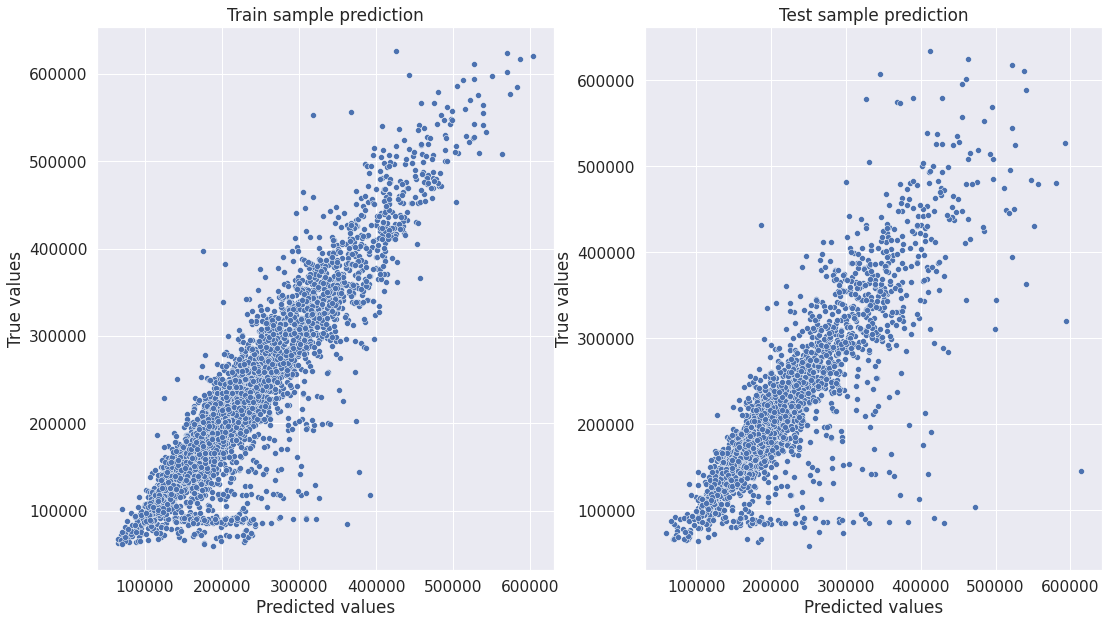

In [86]:
y_train_preds = regr.predict(X_train)
y_test_preds = regr.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [134]:
# max_parametres
regr = GradientBoostingRegressor(max_depth=6, max_features=11,\
                             n_estimators = 125, min_samples_leaf = 5, random_state=65)
regr.fit(X_train, y_train)

# max_parametres
# {'max_depth': 5,
#  'max_features': 11,
#  'min_samples_leaf': 6,
#  'n_estimators': 125}

GradientBoostingRegressor(max_depth=6, max_features=11, min_samples_leaf=5,
                          n_estimators=125, random_state=65)

In [135]:
y_test_preds = regr.predict(X_valid)

In [136]:
test_r2 = r2(y_valid, y_test_preds)
test_r2

0.7369731299004957

In [126]:
feature_importances = pd.DataFrame(zip(X_train.columns, regr.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.406860
9,Social_2,0.109357
8,Social_1,0.091518
10,Social_3,0.081021
0,Rooms,0.070936
7,Ecology_1,0.053924
2,LifeSquare,0.034139
16,HouseYear_old,0.028629
3,KitchenSquare,0.028049
6,HouseYear,0.027310


### Прогнозирование на тестовом датасете

In [127]:
test_df.shape

(5000, 17)

In [129]:
test_df.head(10)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,HouseYear_old
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,24,4378,0,1,1,1,1,1,52
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,2,629,1,0,0,1,1,0,5
2,2.0,59.463678,39.070015,9.0,19,19.0,1977,0.211401,9,1892,0,0,1,1,1,1,45
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,2,475,0,0,0,1,1,1,57
4,1.0,53.837056,39.443392,3.0,8,17.0,1977,0.309479,35,7715,4,0,6,1,1,1,45
5,3.0,87.139994,53.180419,10.0,4,23.0,2011,0.060753,15,2787,2,0,7,1,1,1,11
6,1.0,46.269456,22.820239,11.0,8,17.0,2014,0.072158,2,629,1,0,0,1,1,0,8
7,2.0,48.172969,29.924204,6.0,4,9.0,1974,0.000000,33,7425,1,2,5,1,1,1,48
8,1.0,43.153761,21.017596,9.0,10,17.0,2014,0.007122,1,264,0,0,1,1,1,1,8
9,2.0,62.593787,59.786844,10.0,1,16.0,1981,0.002212,39,7614,3,1,5,1,1,0,41


In [130]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [131]:
predictions = regr.predict(test_df)
predictions

array([163853.80826261, 126314.91753315, 148056.16838671, ...,
       144190.79847447, 196922.97915803, 257115.24396086])

In [132]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163853.808263
1,5925,126314.917533
2,960,148056.168387
3,3848,121074.541151
4,746,183858.575370


In [133]:
submit.to_csv(PREPARED_DATASET_PATH, index=False)